In [27]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np
import os

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN, PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
# Directory containing the .npz files
data_dir = './data'

# Lists to store data from all files
X_list = []
y_list = []

# First, find the maximum number of particles across all files
max_particles = 0
for filename in os.listdir(data_dir):
    if filename.endswith('.npz'):
        data = np.load(os.path.join(data_dir, filename))
        max_particles = max(max_particles, data['X'].shape[1])

# Now load and pad the arrays
for filename in os.listdir(data_dir):
    if filename.endswith('.npz'):
        data = np.load(os.path.join(data_dir, filename))
        x = data['X']
        y = data['y']

        # Pad the particle dimension if needed
        if x.shape[1] < max_particles:
            pad_width = ((0, 0), (0, max_particles - x.shape[1]), (0, 0))
            x = np.pad(x, pad_width, mode='constant')

        X_list.append(x)
        y_list.append(y)

# Concatenate the padded arrays
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (200000, 144, 4), y shape: (200000,)


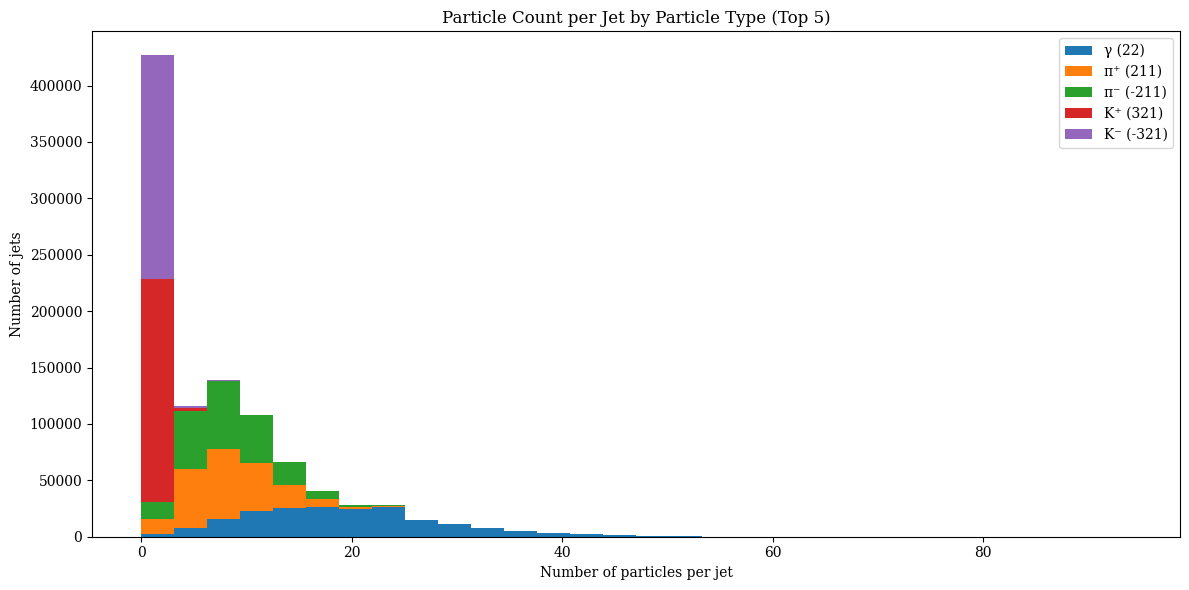

In [32]:
# Extract pt and pid
pt = X[..., 0]
pid = X[..., 3]

# Find real (non-padded) particles
mask = pt > 0

# Convert to integer for matching
pid = pid.astype(int)

# PID-to-particle label mapping
pid_labels = {
    211: 'π⁺',
    -211: 'π⁻',
    111: 'π⁰',
    130: 'K⁰_L',
    310: 'K⁰_S',
    321: 'K⁺',
    -321: 'K⁻',
    2212: 'p',
    -2212: 'p̄',
    2112: 'n',
    -2112: 'n̄',
    22: 'γ',
    11: 'e⁻',
    -11: 'e⁺',
    13: 'μ⁻',
    -13: 'μ⁺',
}

# Get the most common PIDs (e.g., top 5)
unique_pids, counts = np.unique(pid[mask], return_counts=True)
sorted_idx = np.argsort(-counts)
top_pids = unique_pids[sorted_idx[:5]]  # top 5 most frequent PIDs

# Prepare per-jet particle counts per pid
jet_pid_counts = {pid_val: [] for pid_val in top_pids}

# Loop over each jet
for jet_pt, jet_pid in zip(pt, pid):
    real_mask = jet_pt > 0
    real_pids = jet_pid[real_mask]

    for pid_val in top_pids:
        count = np.sum(real_pids == pid_val)
        jet_pid_counts[pid_val].append(count)

# Plot stacked histogram
values = [jet_pid_counts[pid_val] for pid_val in top_pids]
labels = [f'{pid_labels.get(pid_val, "PID "+str(pid_val))} ({pid_val})' for pid_val in top_pids]

plt.figure(figsize=(10, 6))
plt.hist(values, bins=30, stacked=True, label=labels)
plt.xlabel("Number of particles per jet")
plt.ylabel("Number of jets")
plt.title("Particle Count per Jet by Particle Type (Top 5)")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def one_hot_encode_pids(X, pid_to_index, num_pid_types):
    X_new = []

    for jet in X:
        pt = jet[:,0][:, None]  # shape (n, 1)
        yphi = jet[:,1:3]       # shape (n, 2)
        pid = jet[:,3]          # shape (n,)

        # create one-hot encodings
        onehot = np.zeros((jet.shape[0], num_pid_types))
        for i, p in enumerate(pid):
            if p in pid_to_index:
                onehot[i, pid_to_index[p]] = 1

        # combine: pt + yphi + onehot(pid)
        combined = np.concatenate([pt, yphi, onehot], axis=1)
        X_new.append(combined)

    return np.array(X_new)

In [9]:
# handle particle id channel

use_pids = True

for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

if use_pids:
    # Extract unique PID values from the dataset
    pid_vals = np.unique(X[:,:,3][X[:,:,0] > 0])
    pid_to_index = {pid: i for i, pid in enumerate(pid_vals)}
    num_pid_types = len(pid_vals)
    X = one_hot_encode_pids(X, pid_to_index, num_pid_types)
else:
    X = X[:,:,:3]

In [10]:
# convert labels to categorical
Y = to_categorical(y, num_classes=2)

In [13]:
# do train/val/test split

# total number of samples
total = len(X)

# split sizes
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val_size, test=test_size)

print('Done train/val/test split')

Done train/val/test split


In [14]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

new_pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)
new_pfn.model.load_weights('pfn_finetune_weights.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, 17)]           0         []                            
                                                                                                  
 tdist_0 (TimeDistributed)   (None, None, 100)            1800      ['input[0][0]']               
                                                                                                  
 activation_14 (Activation)  (None, None, 100)            0         ['tdist_0[0][0]']             
                                                                                                  
 tdist_1 (TimeDistributed)   (None, None, 100)            10100     ['activation_14[0][0]']       
                                                                                            

In [ ]:
# Make predictions
preds = new_pfn.model.predict(X_test, batch_size=512)

Class 0: 13775 jets (6.89%)
Class 1: 16225 jets (8.11%)


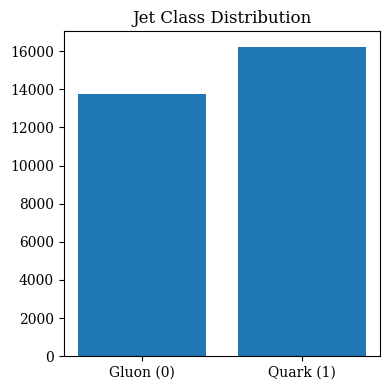

In [24]:
# Check how balanced the dataset is between quark (1) and gluon (0) jets

# Convert probabilities to class labels (0 or 1)
pred_classes = np.argmax(preds, axis=1)

classes, counts = np.unique(pred_classes, return_counts=True)
for cls, cnt in zip(classes, counts):
    print(f"Class {cls}: {cnt} jets ({cnt / len(y) * 100:.2f}%)")

plt.bar(["Gluon (0)", "Quark (1)"], counts)
plt.title("Jet Class Distribution")
plt.show()

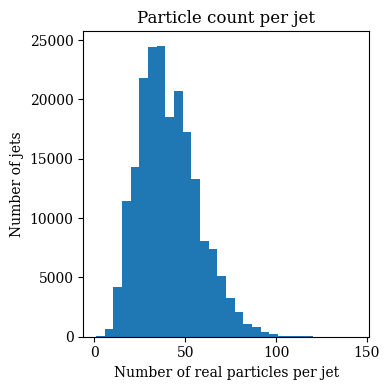

In [25]:
# Count the number of non-padded particles (non-zero pt) in each jet - how "dense" the jets are?

nonzero_counts = np.count_nonzero(X[..., 0], axis=1)  # counting non-zero pt values per jet, because pt=0 indicates a padded (fake) particle

plt.hist(nonzero_counts, bins=30)
plt.xlabel("Number of real particles per jet")
plt.ylabel("Number of jets")
plt.title("Particle count per jet")
plt.show()

In [18]:
# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print('PFN AUC:', auc)

59/59 [==============================] - 3s 43ms/step
PFN AUC: 0.8038511163827633


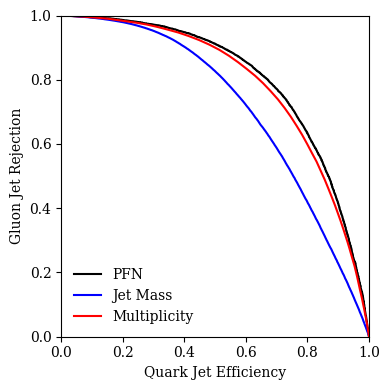

In [19]:
# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()